In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from subprocess import check_call

import dask
from dask.distributed import Client

import pandas as pd
import xarray as xr

import papermill as pm

import oae_smyle
import validate_case

In [3]:
df_caseinfo = oae_smyle.get_caseinfo()
cases = df_caseinfo.loc[(df_caseinfo.run) & (~df_caseinfo.error)].index.to_list()
cases += [
    "smyle.control.perlmutter.004",
    "validation_smyle.oae.perlmutter.alk-forcing-lat-range-basin_000.001.ipynb"
]
cases

['smyle.oae-map.North_Atlantic_basin.000.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.000.1999-04-01.002',
 'smyle.oae-map.North_Atlantic_basin.000.1999-04-01.003',
 'smyle.oae-map.North_Atlantic_basin.000.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.001.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.001.1999-07-01.001',
 'smyle.oae-map.North_Atlantic_basin.001.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.002.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.002.1999-07-01.001',
 'smyle.oae-map.North_Atlantic_basin.002.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.003.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.003.1999-07-01.001',
 'smyle.oae-map.North_Atlantic_basin.003.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.004.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.004.1999-07-01.001',
 'smyle.oae-map.North_Atlantic_basin.004.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.005.1999-04-01.001',
 'smyle.oae-ma

## Spin up dask cluster

Run in shell:
```bash
salloc -N 4 -n 64 -t 04:00:00 -C cpu -q interactive
```

Once that allocation is active, launch the `dask-scheduler`:
```bash
./launch-dask.sh
```

In [4]:
scheduler_file = os.path.join(os.environ["SCRATCH"], "scheduler_file.json")

dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status" 
client = Client(scheduler_file=scheduler_file)
client

<Client: 'tcp://10.249.1.247:8786' processes=64 threads=16384, memory=29.79 TiB>

2024-09-08 06:47:11,853 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [18]:
clobber = False

rows = []
for case in cases:
    
    print("=" * 80)
    print(case, end="\n")
    
    is_oae_run = ".oae-map." in case
    zarr_store = validate_case.zarr_validation_data(case)
           
    row_data = dict(case=case, is_oae_run=is_oae_run)
    
    if not os.path.exists(zarr_store) or clobber:
        ds_out = validate_case.validator(case, is_oae_run)
        if ds_out is None:
            continue

        ds_out = ds_out.compute() 
                    
        print(f"writing {zarr_store}")
        ds_out.to_zarr(
            zarr_store,
            mode="w",
            consolidated=True,
        )
    else:
        print(f"reading {zarr_store}")
        ds_out = xr.open_zarr(zarr_store).compute()

    for v in ds_out.variables:
        if v[-5:] == "_rmse":
            rmse_max = ds_out[v].max().values.item()
            
            #if is_oae_run and "ALT_CO2" in v:
            row_data[v] = rmse_max
            
    rows.append(row_data)
    
df = pd.DataFrame(rows).set_index("case")
df

smyle.oae-map.North_Atlantic_basin.000.1999-04-01.001
reading /global/cfs/projectdirs/m4746/Projects/OAE-Efficiency-Map/data/Case-Validation/smyle.oae-map.North_Atlantic_basin.000.1999-04-01.001.diff.zarr
smyle.oae-map.North_Atlantic_basin.000.1999-04-01.002
reading /global/cfs/projectdirs/m4746/Projects/OAE-Efficiency-Map/data/Case-Validation/smyle.oae-map.North_Atlantic_basin.000.1999-04-01.002.diff.zarr
smyle.oae-map.North_Atlantic_basin.000.1999-04-01.003
reading /global/cfs/projectdirs/m4746/Projects/OAE-Efficiency-Map/data/Case-Validation/smyle.oae-map.North_Atlantic_basin.000.1999-04-01.003.diff.zarr
smyle.oae-map.North_Atlantic_basin.000.1999-10-01.001
reading /global/cfs/projectdirs/m4746/Projects/OAE-Efficiency-Map/data/Case-Validation/smyle.oae-map.North_Atlantic_basin.000.1999-10-01.001.diff.zarr
smyle.oae-map.North_Atlantic_basin.001.1999-04-01.001
reading /global/cfs/projectdirs/m4746/Projects/OAE-Efficiency-Map/data/Case-Validation/smyle.oae-map.North_Atlantic_basin.001.

,is_oae_run,ALK_ALT_CO2_rmse,DIC_ALT_CO2_rmse,DOC_rmse,DOCr_rmse,DON_rmse,DONr_rmse,DOP_rmse,DOPr_rmse,Fe_rmse,...,diazFe_rmse,diazP_rmse,spC_rmse,spCaCO3_rmse,spChl_rmse,spFe_rmse,spP_rmse,zooC_rmse,ALK_rmse,DIC_rmse
case,,,,,,,,,,,,,,,,,,,,,
smyle.oae-map.North_Atlantic_basin.000.1999-04-01.001,True,0.254084,0.390808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smyle.oae-map.North_Atlantic_basin.000.1999-04-01.002,True,0.254084,0.390808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smyle.oae-map.North_Atlantic_basin.000.1999-04-01.003,True,0.254084,0.390808,0.052529,0.011433,0.004822,0.000261,0.000273,0.000002,0.000004,...,3.141151e-08,0.000004,0.011294,0.002429,0.002284,2.898923e-07,0.000084,0.012299,NaN,NaN
smyle.oae-map.North_Atlantic_basin.000.1999-10-01.001,True,0.251894,0.292239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smyle.oae-map.North_Atlantic_basin.001.1999-04-01.001,True,0.219329,0.350099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
smyle.oae-map.North_Atlantic_basin.031.1999-04-01.001,True,0.269345,0.300496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smyle.oae-map.North_Atlantic_basin.031.1999-10-01.001,True,0.257148,0.308847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smyle.oae-map.North_Atlantic_basin.032.1999-04-01.001,True,0.246361,0.313212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: ylabel='Frequency'>

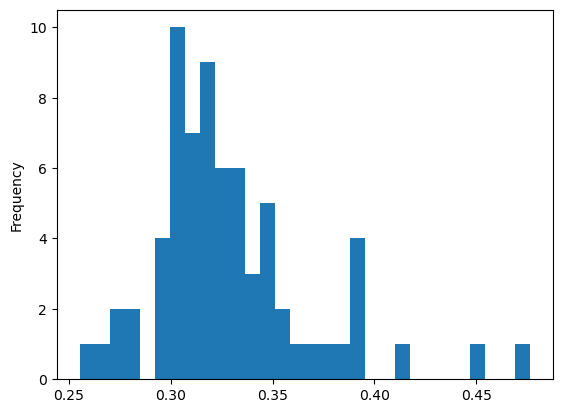

In [20]:
df.DIC_ALT_CO2_rmse.plot.hist(bins=30)

<Axes: ylabel='Frequency'>

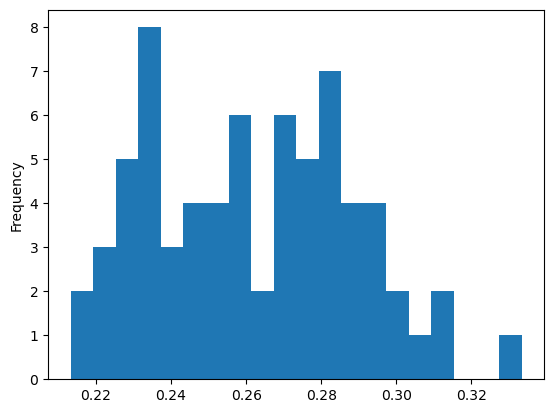

In [21]:
df.ALK_ALT_CO2_rmse.plot.hist(bins=20)

In [16]:
clobber = True

dir_out = "case-info/validation"
os.makedirs(dir_out, exist_ok=True)

for case in cases:   
    nb_out = f"{dir_out}/validation_{case}.ipynb"
    if os.path.exists(nb_out) and not clobber:
        continue
    
    zarr_store = validate_case.zarr_validation_data(case)    
    if os.path.exists(zarr_store):
        pm.execute_notebook(
           "plot_case_validation.ipynb",
           nb_out,
           parameters=dict(case=case)
        )

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

Executing:   0%|          | 0/6 [00:00<?, ?cell/s]

In [4]:
print("done")

done
